### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.2
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("ner_dataset.csv",encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [6]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [7]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w, p, t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [10]:
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [11]:
word2idx

{'mockery': 1,
 'atolls': 2,
 'Drik': 3,
 'Faroese': 4,
 'mistrial': 5,
 'undisclosed': 6,
 'remembrances': 7,
 'Walayo': 8,
 'Bakara': 9,
 'mid-term': 10,
 'Saldanha': 11,
 'feathers': 12,
 'semi-annual': 13,
 'element': 14,
 'selections': 15,
 'skillful': 16,
 'measures': 17,
 'semblance': 18,
 'Hung': 19,
 'opportunities': 20,
 '102-member': 21,
 'seeks': 22,
 '1829': 23,
 ';': 24,
 'avarice': 25,
 'Annapolis': 26,
 'krill': 27,
 'exclusion': 28,
 'cart': 29,
 'notion': 30,
 'circumscribed': 31,
 'Winston': 32,
 'McAlpine': 33,
 'Sugiarto': 34,
 'Kor': 35,
 'hovered': 36,
 'Rajasthan': 37,
 'Delhi': 38,
 'Soccer': 39,
 'Baucus': 40,
 'passenger': 41,
 'tightly-guarded': 42,
 'highlighting': 43,
 'outlook': 44,
 'Ophelia': 45,
 'Drapchi': 46,
 'alleged': 47,
 'Pulling': 48,
 'book': 49,
 'wrap': 50,
 'simply': 51,
 'Musayyib': 52,
 'Crocker': 53,
 'Seng': 54,
 'dynamic': 55,
 'Girona': 56,
 'Kalam': 57,
 'Bajur': 58,
 'Arnoldo': 59,
 'Recovery': 60,
 'domestically': 61,
 'intervening

### Task 5: Padding Input Sentences and Creating Train/Test Splits

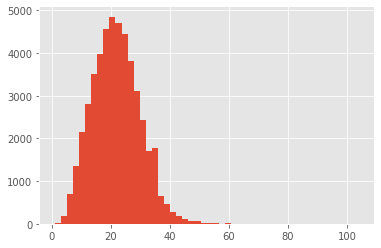

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post',value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post',value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])

In [19]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 6.9 MB/s 
     |████████████████████████████████| 381 kB 56.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.


### Task 7: Train the Model

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [21]:
from livelossplot import PlotLossesKeras


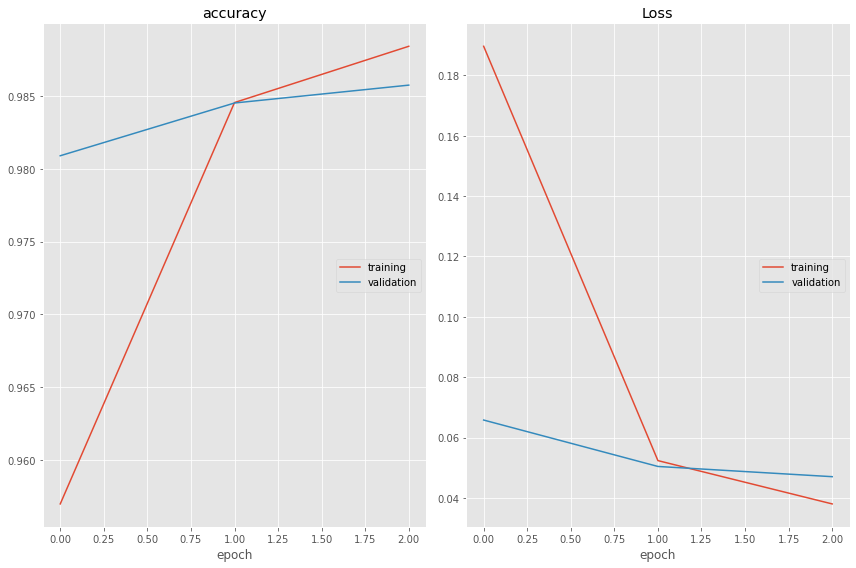

accuracy
	training         	 (min:    0.957, max:    0.988, cur:    0.988)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.038, max:    0.190, cur:    0.038)
	validation       	 (min:    0.047, max:    0.066, cur:    0.047)
1080/1080 [==============================] - 382s 354ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0470 - val_accuracy: 0.9857


In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(x_train, np.array(y_train),
                   validation_split = 0.2,
                   batch_size=32,
                   epochs=3,
                   verbose=1,
                   callbacks=callbacks)

### Task 8: Evaluate Named Entity Recognition Model

In [23]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 32ms/step - loss: 0.0492 - accuracy: 0.9852


[0.049241453409194946, 0.9851751327514648]

In [24]:
i = np.random.randint(0,x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O	O
103            O	O
nuclear        O	O
power          O	O
plants         O	O
in             O	O
31             O	B-tim
states         O	O
.              O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld        O	O
Rotfeld  